In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import yfinance as yf
import requests
from bs4 import BeautifulSoup
import matplotlib.dates as mdates
from scipy.stats import pearsonr 

In [3]:
file_path = "../data/raw/minimun_wage.csv"
# 인코딩을 'euc-kr'로 설정하여 파일 읽기
df = pd.read_csv(file_path, encoding='euc-kr')

# 1️⃣ '적용연도'를 datetime 형식으로 변환
df['적용연도(1년 지속)'] = pd.to_datetime(df['적용연도(1년 지속)'])
df
# # 2️⃣ 시각화
# plt.figure(figsize=(12, 6))
# plt.plot(df['적용연도(1년 지속)'], df['시간급'], marker='o', color='green', linestyle='-', linewidth=2)
# plt.title('연도별 시간급 변화')
# plt.xlabel('적용연도')
# plt.ylabel('시간급 (원)')
# plt.gca().invert_yaxis()
# plt.grid(True)
# plt.xticks(rotation=45)  # X축 라벨 회전
# plt.show()

,적용연도(1년 지속),시간급,일급(8시간 기준),월급(209시간,인상률(인상액),심의,결정
0,2025-01-01,"10,030","80,240","2,096,270",1.7 (170),24.07.12,24.08.05
1,2024-01-01,"9,860","78,880","2,060,740",2.5 (240),23.07.19,23.08.04
2,2023-01-01,"9,620","76,960","2,010,580",5.0 (460),22.06.29,22.08.05
3,2022-01-01,"9,160","73,280","1,914,440",5.05 (440),21.07.12,21.08.05
4,2021-01-01,"8,720","69,760","1,822,480",1.5 (130),20.07.14,20.08.05
5,2020-01-01,"8,590","68,720","1,795,310",2.87 (240),19.07.12,19.08.05


In [4]:
price_file_path = "../data/raw/ikh_item_price_2025-01-15.csv"
price_df = pd.read_csv(price_file_path)
price_df['priceDate'] = pd.to_datetime(price_df['priceDate'], errors='coerce')
price_df

,priceDate,minPrice,avgPrice,maxPrice,item,market
0,2015-03-06,20000,20000,20000,농어,노량진 1층
1,2015-03-14,25000,25000,25000,농어,노량진 1층
2,2015-04-18,25000,27500,30000,농어,노량진 1층
3,2015-04-28,25000,25000,25000,농어,노량진 1층
4,2015-05-18,25000,25000,25000,농어,노량진 1층
...,...,...,...,...,...,...
131770,2020-12-20,30000,30000,30000,방어,부산민락어민활어직판장
131771,2020-12-21,30000,30000,30000,방어,부산민락어민활어직판장
131772,2020-12-23,30000,30000,30000,방어,부산민락어민활어직판장
131773,2020-12-24,30000,30000,30000,방어,부산민락어민활어직판장


[*********************100%***********************]  1 of 1 completed


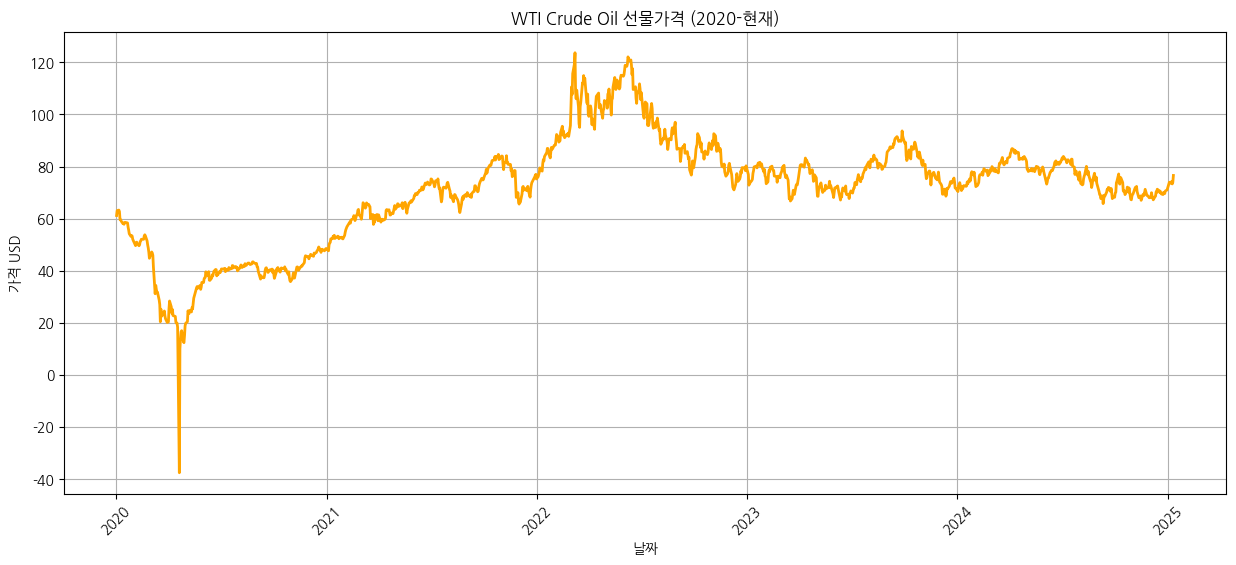

In [5]:
# 1️⃣ WTI Crude Oil 티커(symbol) 설정
oil_data = yf.download('CL=F', start='2020-01-01', end='2025-01-12')

# 2️⃣ 'Close' 가격을 기준으로 시각화
plt.figure(figsize=(15, 6))
plt.plot(oil_data.index, oil_data['Close'], color='orange', linewidth=2)
plt.title('WTI Crude Oil 선물가격 (2020-현재)')
plt.xlabel('날짜')
plt.ylabel('가격 USD')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

[*********************100%***********************]  1 of 1 completed


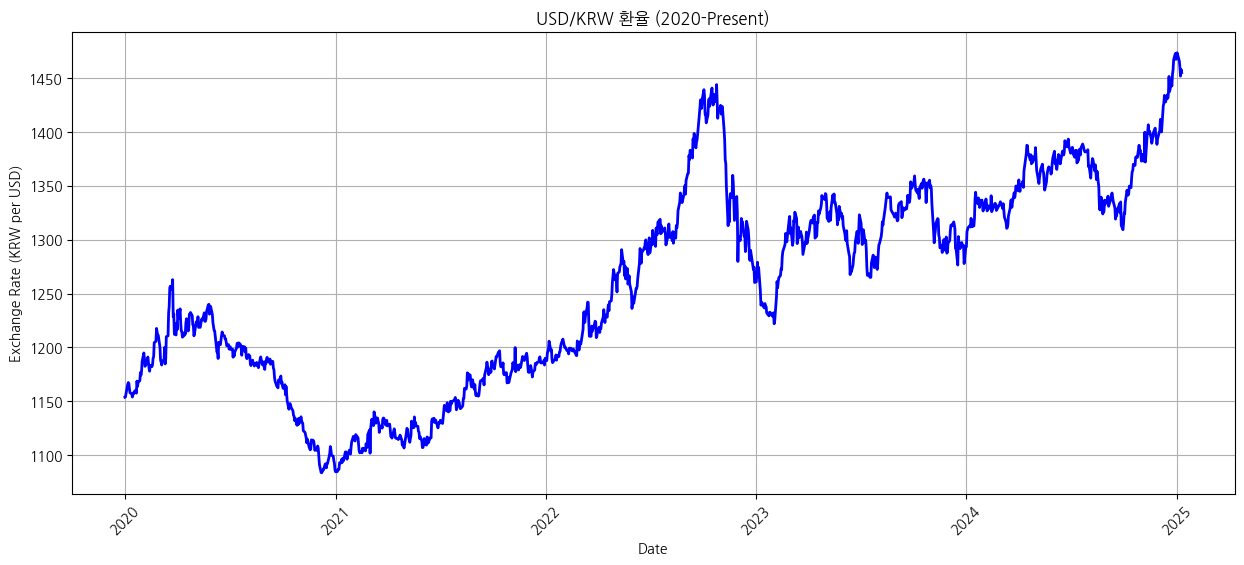

In [6]:
# 1️⃣ USD/KRW 환율 데이터 가져오기
krw_usd = yf.download('KRW=X', start='2020-01-01', end='2025-01-12')

# 2️⃣ 'Close' 가격을 기준으로 시각화
plt.figure(figsize=(15, 6))
plt.plot(krw_usd.index, krw_usd['Close'], color='blue', linewidth=2)
plt.title('USD/KRW 환율 (2020-Present)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (KRW per USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

WTI          0
USD/KRW      0
광어           2
농어           2
대게           4
방어         823
연어           2
우럭         888
참돔           3
dtype: int64


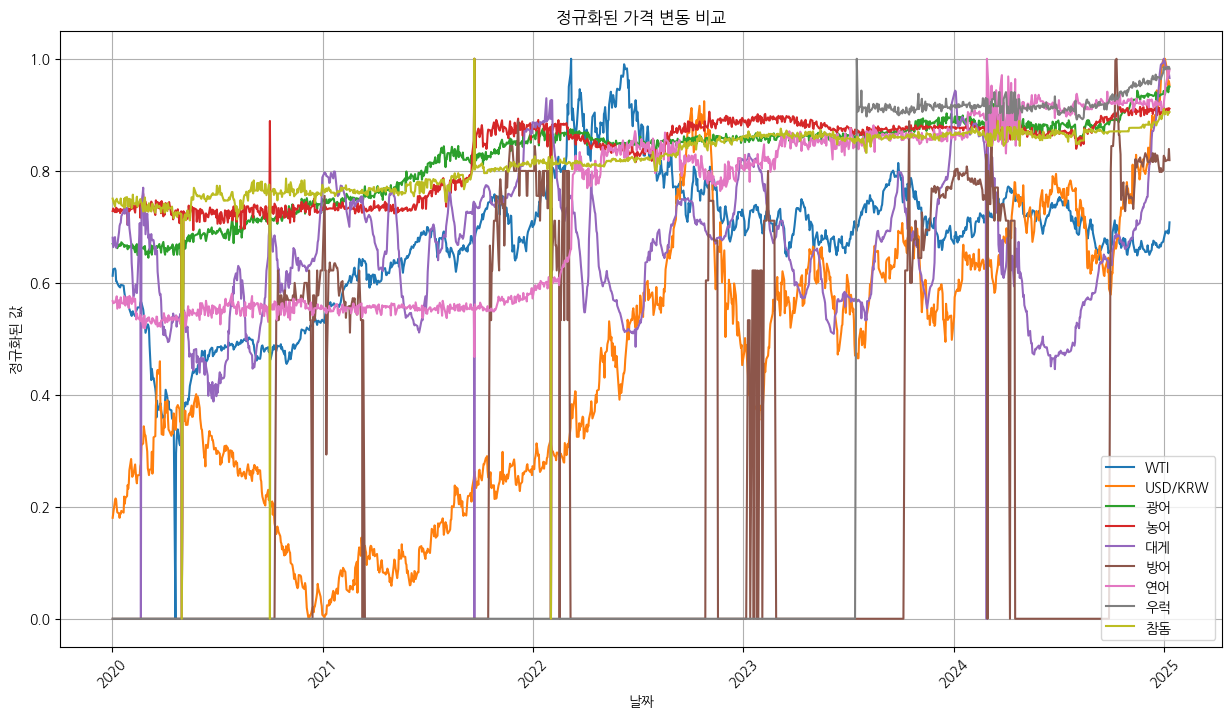

         WTI   USD/KRW
광어  0.714459  0.635105
농어  0.638076  0.692274
대게  0.218977  0.023936
방어  0.047663  0.062981
연어  0.590572  0.874932
우럭  0.201500  0.640202
참돔  0.511175  0.654924


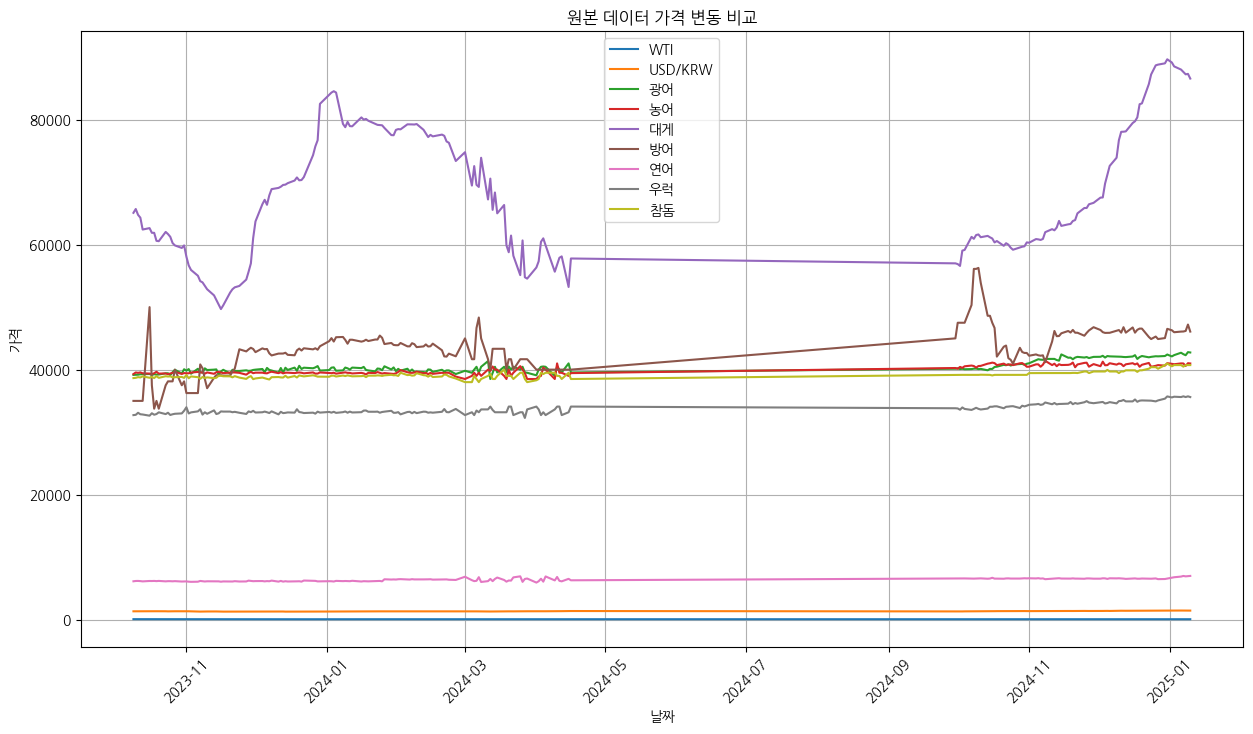

In [15]:
# Load item price data
file_path = '../data/raw/ikh_item_price_2025-01-15.csv'
price_df = pd.read_csv(file_path)
price_df['priceDate'] = pd.to_datetime(price_df['priceDate'], errors='coerce')

# Filter item price data and group by date and item for average price
item_avg_prices = price_df.groupby(['priceDate', 'item'])['avgPrice'].mean().unstack()


# 데이터를 1차원 Series로 변환
aligned_data = pd.DataFrame({
    'WTI': oil_data['Close'].squeeze(),  # 2D인 경우 1D로 변환
    'USD/KRW': krw_usd['Close'].squeeze()  # 2D인 경우 1D로 변환
}, index=oil_data.index)

aligned_data = aligned_data.merge(item_avg_prices, how='inner', left_index=True, right_index=True)

print(aligned_data.isnull().sum()) 
# 결측값을 0으로 채우기
aligned_data = aligned_data.fillna(0)

# 데이터를 비교하기 위해 정규화
normalized_data = aligned_data.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# 데이터 시각화
plt.figure(figsize=(15, 8))
for column in normalized_data.columns:
    plt.plot(normalized_data.index, normalized_data[column], label=column)
plt.title('정규화된 가격 변동 비교')
plt.xlabel('날짜')
plt.ylabel('정규화된 값')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Pearson 상관계수를 계산 (WTI 및 USD/KRW와 비교)
# raw_data = aligned_data.dropna()  # 결측값 제거
correlations = {}
for item in item_avg_prices.columns:
    if item in normalized_data.columns:
        corr_wti, _ = pearsonr(normalized_data['WTI'], normalized_data[item])
        corr_usd, _ = pearsonr(normalized_data['USD/KRW'], normalized_data[item])
        correlations[item] = {'WTI': corr_wti, 'USD/KRW': corr_usd}

# 상관계수 결과 출력
correlation_df = pd.DataFrame(correlations).T
print(correlation_df)

# 시각화 (정규화 없이 원본 데이터)
plt.figure(figsize=(15, 8))
for column in raw_data.columns:
    plt.plot(raw_data.index, raw_data[column], label=column)
plt.title('원본 데이터 가격 변동 비교')
plt.xlabel('날짜')
plt.ylabel('가격')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()